# GMM 

- 가우시안 분포를 가정하는 모수적 추론 방법임
- 클러스터링 해줄 개수를 미리 설정해야 함

In [1]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [4]:
# GMM 적용
from sklearn.mixture import GaussianMixture
# n_components로 미리 군집 개수 설정
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(iris.data)

# GMM 후 클러스터링 레이블을 따로 설정
irisDF['gmm_cluster'] = gmm_labels

# 실제 레이블과 GMM 클러스터링 후 레이블과 비교해보기(두 레이블 수치가 동일해야 똑같은 레이블 의미 아님!)
irisDF.groupby('target')['gmm_cluster'].value_counts()

target  gmm_cluster
0       2              50
1       0              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64

In [6]:
#이번엔 Kmeans로 클러스터링 해보기
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,
               random_state=42)
kmeans_label = kmeans.fit_predict(iris.data)
irisDF['kmeans_label'] = kmeans_label

irisDF.groupby('target')['kmeans_label'].value_counts()

target  kmeans_label
0       1               50
1       0               48
        2                2
2       2               36
        0               14
Name: kmeans_label, dtype: int64

In [7]:
# 클러스터링 결과 시각화 함수
def visualize_cluster_plot(clusterobj, df, label_name, iscenter=True):
    #비모수방법인 K-means나 MeanShift는 클러스터 중심좌표를 반환
    if iscenter:
        centers = clusterobj.cluster_centers_
    
    unique_labels = np.unique(df[label_name].values)
    markers = ['^','o','s','x','*']
    isNoise = False
    
    for label in unique_labels:
        label_cluster = df[df[label_name]==label]
        # DBSCAN에서 배울내용임
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else:
            cluster_legend = 'Cluster'+str(label)
        #개별 데이터 분포도 시각화
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'],
                   s=70, edgecolor='k', marker=markers[label],
                   label=cluster_legend)
        # K-means, MeanShift일 때 클러스터링 중심좌표 표시, 시각회
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250,
                       color='white', alpha=0.9, edgecolor='k',
                       marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70,
                       color='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else:
        legend_loc='upper right'
    plt.legend(loc=legend_loc)
    plt.show()

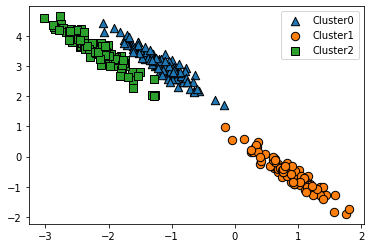

In [10]:
# GMM 군집화에 맞는 데이터 생성
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, n_features=2, centers=3,
                 cluster_std=0.5, random_state=0)
# 긴 타원형 데이터 분포 만들기 위해 인위적 변환 가함
# 길게 늘어난 타원형의 데이터 셋을 생성하기 위해 변환함. 
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

# 군집화용 생성 데이터프레임 만들기
cluster_df = pd.DataFrame(data=X_aniso, columns=['ftr1','ftr2'])
cluster_df['target'] = y

# 클러스터링 시각화
visualize_cluster_plot(None, cluster_df, 'target', iscenter=False)

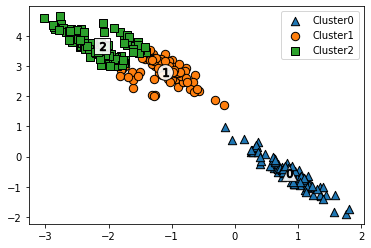

In [11]:
# 위에 생성한 데이터로 K-means 군집화수행
kmeans = KMeans(n_clusters=3, random_state=12)
kmeans_label = kmeans.fit_predict(X_aniso)
cluster_df['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, cluster_df, 'kmeans_label', iscenter=True)

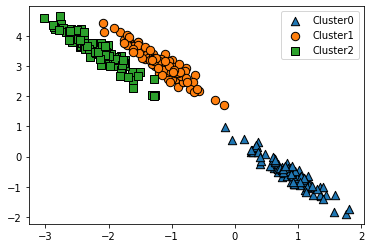

In [12]:
# 이번엔 GMM 군집화 수행
gmm = GaussianMixture(n_components=3, random_state=12)
gmm_label = gmm.fit_predict(X_aniso)
cluster_df['gmm_label'] = gmm_label

visualize_cluster_plot(gmm, cluster_df, 'gmm_label', iscenter=False)

<군집화 모델 정리>
- K-means(semi-parametric)
    * 사전에 군집화 개수 설정
- MeanShift(non-parametric)
    * KDE(비모수 추론방법) 이용하기 때문에 사전 군집 개수 지정안함
    * bandwidth가 중요파라미터 이며 이로 인해 군집개수 결정됨
- GMM(parametric)
    * 모수 추론방법
    * 사전에 군집화 개수 설정